# CNN redes convolucionales Jorge Cueva - Cinthya Ramon

Durante esta práctica se busca utilizar el dataset de imagenes food101 de tensorflow datasets, para entrenar una red convolucional.
Objetivos:
- Realizar una introducción al dataset
- Realizar un un analisis exploratorio
- Desarrollar, entrenar y optimizar una red convolucional.
- Predecir nuevas imagenes.






El documento ahora, está compuesto en partes, cada una correspondiente a una de las órdenes de la práctica. seguido de la siguiente forma

## Índice

1. [Descripción del problema y dataset](#1-descripción-del-problema-y-dataset)  
2. [Análisis exploratorio](#2-análisis-exploratorio)  
3. [Red neuronal](#3-red-neuronal)  
   - [3.1 Desarrollo](#31-desarrollo)  
   - [3.2 Entrenamiento](#32-entrenamiento)  
   - [3.3 Optimización de la red](#33-optimización-de-la-red)  
4. [Evaluación con el conjunto de test](#4-evaluación-con-el-conjunto-de-test)  
5. [Predicciones](#5-predicciones)  
6. [Conclusiones](#6-conclusiones)  
7. [Referencias](#7-referencias)  

## 1. Descripción del problema y dataset

El dataset food101 está conformado por 101 categorías y 101000 imágenes. 

Para cada clase existen 1000 imagenes conformadas en 250 para pruebas y 750 para entrenamiento.

Todas las imágenes tienen un tamaño de 512 pixeles de ancho.

El link de información principal del dataset es el siguiente [Link del dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

### 1.1 Carga del dataset.

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Dispositivo activo:", tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dispositivo activo: /device:GPU:0


In [2]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2 as cv
import os
from keras.models import Sequential
from keras.layers import Flatten, Dense
import numpy as np
from PIL import Image 


In [3]:

with open("food-101/meta/train.txt") as f:
    train_files = [os.path.join("food-101/images", line.strip() + ".jpg") for line in f]

with open("food-101/meta/test.txt") as f:
    test_files = [os.path.join("food-101/images", line.strip() + ".jpg") for line in f]


## 2. Análisis exploratorio

### 2.1 Información de los datos

El dataset cuenta con 101 clases de comida. 
El conjunto de datos, contiene 2 carpetas importantes, images, que contiene en subcarpetas todas imagenes de cada categoría, y meta, que contiene información para la configuración del dataset. clases y labels que son lo mismo con una sintaxis distinta, y el conjunto de test y train que indican cuales con los datos de entrenamiento y los de evaluación conforme la disposición del dataset 25% para pruebas y 75% para entrenamiento.

Tambien podemos ver las dimesiones de las imagenes, ya que todas tienen 512 de ancho, pero el alto varía.

### 2.2 Visualización de datos

Un solo dato

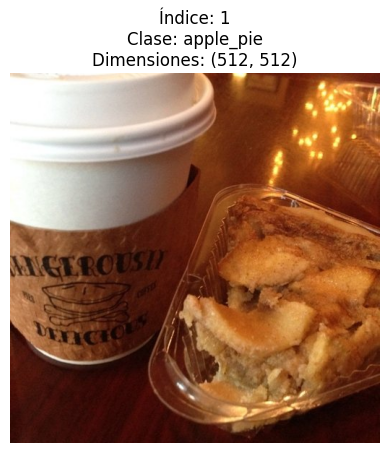

In [4]:
#obteniendolo directamente del sistema operativo.

index = 1  
image_path = train_files[index]
class_name = os.path.basename(os.path.dirname(image_path)) 
image = Image.open(image_path)



plt.imshow(image)
plt.axis('off')
plt.title(f"Índice: {index}\nClase: {class_name}\nDimensiones: {image.size}")
plt.show()

tfds.showExamples(), se encuentra en la documentación de tensorflow para visualización de datos. muestro entonces datos de entrenamiento y validacion (pruebas)

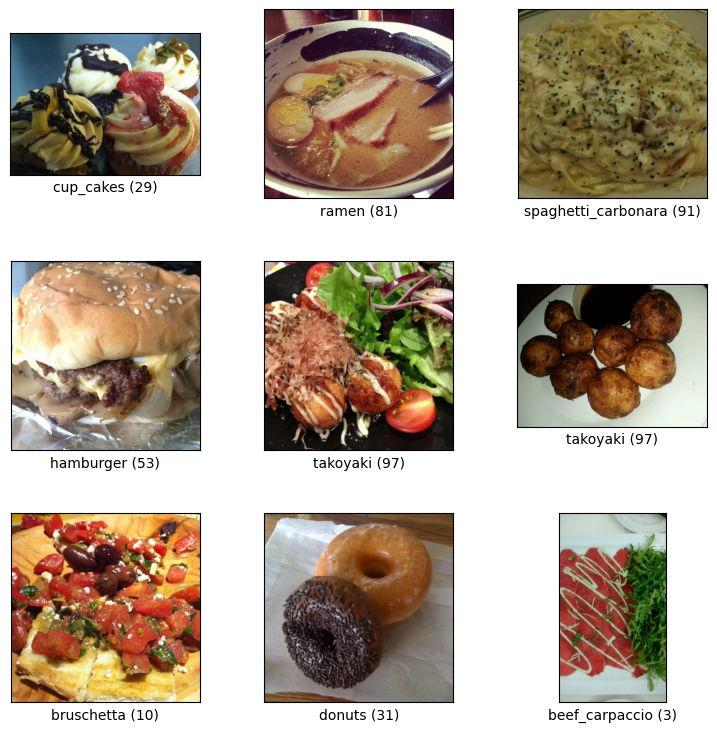

In [5]:
#Cargandolo y utilizando show_examples

builder = tfds.builder("food101", data_dir="food-101/")
builder.download_and_prepare()

ds_validation = builder.as_dataset(split="validation", as_supervised=True)
info_validation = builder.info
tfds.show_examples(ds_validation,info_validation)
print()

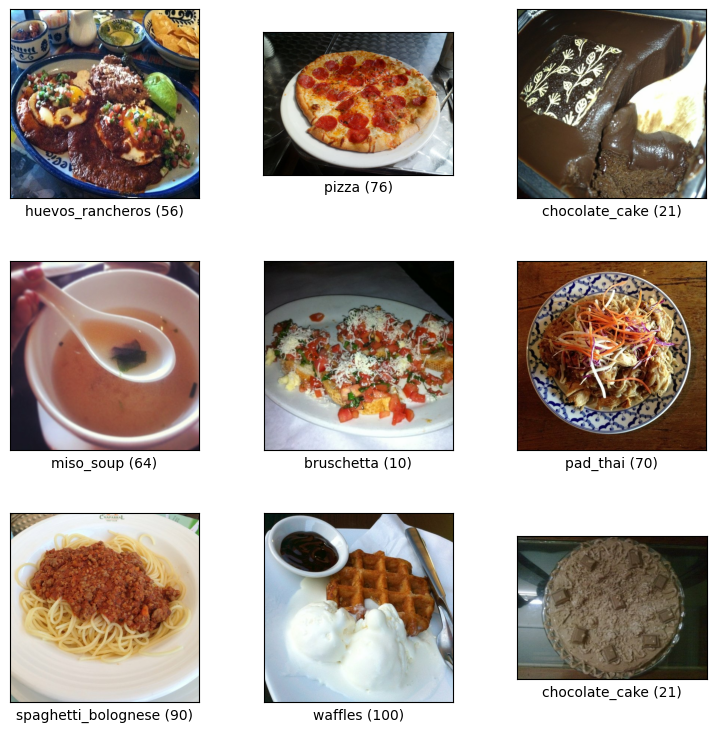

In [6]:

ds_train = builder.as_dataset(split="train", as_supervised=True)
info_train = builder.info


tfds.show_examples(ds_train,info_train)
print()

(0) cup_cakes (382, 512, 3)


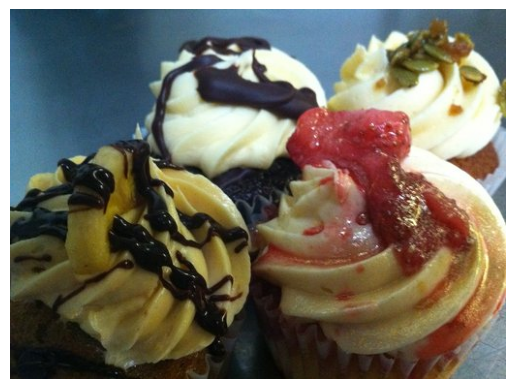


(0) huevos_rancheros (512, 512, 3)


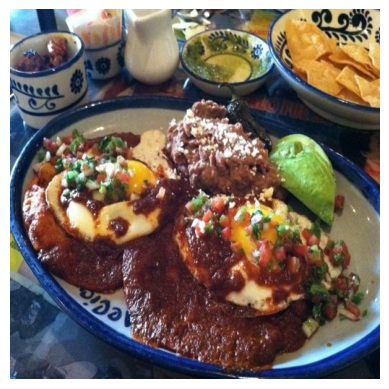

In [7]:
#Se utilizan los mismos dataset que antes, pero en un for que toma los que quiero
for i, (image, label) in enumerate(ds_validation.take(1)):
    print(f"({i}) {builder.info.features['label'].int2str(label)} {image.shape}") #Imprimo su posicion, label, y dimensiones
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print()
for i, (image, label) in enumerate(ds_train.take(1)):
    print(f"({i}) {builder.info.features['label'].int2str(label)} {image.shape}") #Imprimo su posicion, label, y dimensiones
    plt.imshow(image)
    
    plt.axis("off")
    plt.show()
    print()


## 3. Red Neuronal

Una vez que tenemos el dataset podemos empezar con el desarrollo de la red. utilizaremos para ello:


### 3.0.1 Preparación del dataset.

Dado que las imagenes del dataset se encuentran en dimensiones distintas, lo primero va a ser tener que rehacerlas en un tamaño fijo. 
y cómo se va a tener que hacer con todas, definimos funcion y la comprobamos

In [8]:

def resizeImg(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (100,100))
    return image, label


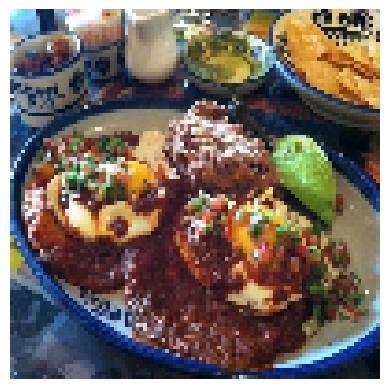

In [9]:
# y comprobamos con una que sepamos tiene otra forma, como la de cupcakes que tiene un tamaño de 382,512
imagen, label = next(iter(ds_train.take(1)))

img, label = resizeImg(imagen, label)
plt.imshow(img)
plt.axis("off")
plt.show()
print()


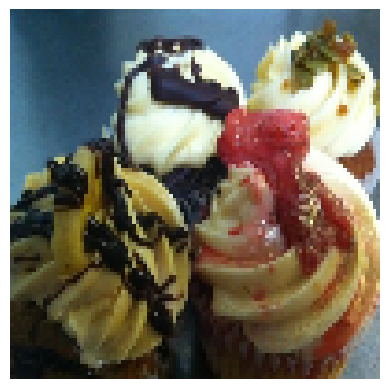

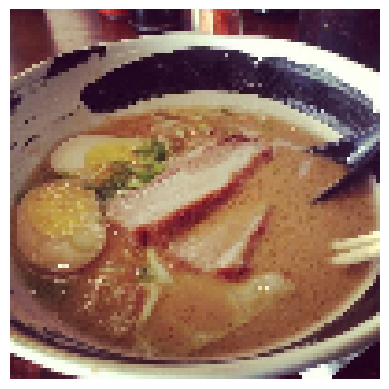

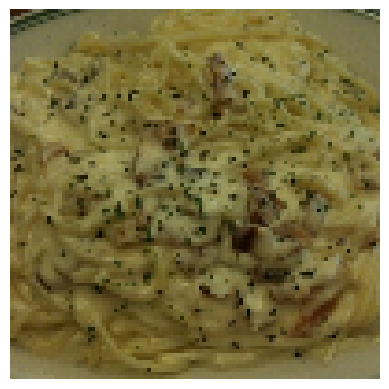

In [10]:
#Rehacemos los datasets de entrenamiento y pruebas y comprobamos que funcione bien

ds_validation = ds_validation.map(resizeImg)
ds_train = ds_train.map(resizeImg)


for i, (image, label) in enumerate(ds_validation.take(3)):
    print()
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print()

###     3.1 Desarrollo

In [11]:
batch_size = 10

imagen,label = next(iter(ds_train.take(1)))

    
model = Sequential()
model.add(Flatten(input_shape=(100, 100, 3)))# agrego una capa sin funcion de activacion que será el input de las imagenes
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))   
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
#en la última capa tiene que haber tantas neuronas como clases haya, en este caso 101
model.add(Dense(101, activation='softmax'))

#compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



### 3.2 Entrenamiento

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 32)                960032    
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4

In [13]:
# ...existing code...
batch_size = 64  # Puedes ajustar este valor según tu GPU

ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size).prefetch(tf.data.AUTOTUNE)

with tf.device('/GPU:0'):
    history = model.fit(ds_train, validation_data=ds_validation, epochs=10)
# ...existing code...

Epoch 1/10
1184/1184 [==============================] - 35s 29ms/step - loss: 4.5448 - accuracy: 0.0168 - val_loss: 4.5127 - val_accuracy: 0.0202
Epoch 2/10
1183/1184 [============================>.] - ETA: 0s - loss: 4.4544 - accuracy: 0.0280

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


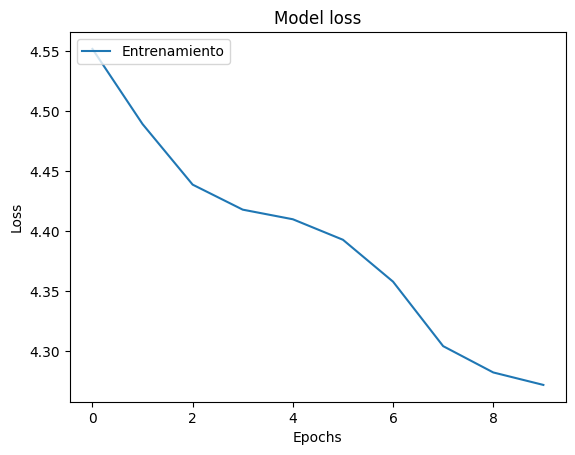

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento'], loc='upper left')
#plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [ ]:
# ds_validation = ds_validation.map(resizeImg).batch(batch_size).prefetch(tf.data.AUTOTUNE)


model.evaluate(ds_validation,verbose=1)

790/790 [==============================] - 11s 14ms/step - loss: 4.2398 - accuracy: 0.0577


[4.239797115325928, 0.05774257332086563]

### 3.3 Optimización de la red

## 4. Evaluación con el conjunto de test

## 5. Predicciones

## 6. Conclusiones

## 7. Referencias